In [1]:
import bagpy
from bagpy import bagreader
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from functools import reduce
from scipy.spatial.transform import Rotation
import ipympl

%matplotlib widget


In [2]:
sns.set_theme()
# LaTex must be installed for this to work
# sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended cm-super

plt.rcParams['text.usetex'] = True
plt.rc('text.latex', preamble=r'\usepackage{bm}')

def drop_columns_in_df(df):
    return df.drop(columns=["header.seq", "header.stamp.secs", "header.stamp.nsecs", "header.frame_id"])

def rename_columns(df, new_colum_names: list):
    column_names = ['Time'] + new_colum_names
    
    df.columns= column_names

    return df

def normalize_df_time(df):
    start_time = df['Time'].iloc[0]

    df['Time'] -= start_time

    return df

def sync_dfs_based_on_time(dataframes: list):
    df_merged = reduce(lambda left,right: pd.merge_asof(left, right, on="Time", allow_exact_matches=True, direction="nearest", tolerance=0.01), dataframes)

    return df_merged

def df_from_pose_to_euler(df):
    quat_df = df[['pose.orientation.x', 'pose.orientation.y', 'pose.orientation.z', 'pose.orientation.w']]
    rot = Rotation.from_quat(quat_df)
    rot_euler = rot.as_euler('xyz', degrees=True)
    euler_df = pd.DataFrame(data=rot_euler, columns=['roll', 'pitch', 'yaw'])

    conc = [df, euler_df]

    df_gt_euler = pd.concat(
        conc,
        axis=1,
        join="outer",
        ignore_index=False,
        keys=None,
        levels=None,
        names=None,
        verify_integrity=False,
        copy=True,
    )

    df_gt_euler = drop_columns_in_df(df_gt_euler)
    df_gt_euler.drop(columns=["pose.position.x", "pose.position.y", "pose.position.z", "pose.orientation.x", "pose.orientation.y","pose.orientation.z","pose.orientation.w"], inplace=True)

    return df_gt_euler

In [24]:
b = bagreader('/home/msccomputer/catkin_ws/src/msc_thesis/test_tools/scripts/live_rosbaging/rosbags/lab/eval_new_PT/test1/2023-03-24-15-46-31.bag')

b.topic_table

[INFO]  Successfully created the data folder /home/msccomputer/catkin_ws/src/msc_thesis/test_tools/scripts/live_rosbaging/rosbags/lab/eval_new_PT/test1/2023-03-24-15-46-31.


,Topics,Types,Message Count,Frequency
0,/anafi/attitude,geometry_msgs/QuaternionStamped,908,29.902500
1,/anafi/gnss_location,sensor_msgs/NavSatFix,908,29.858648
2,/anafi/gnss_ned_in_body_frame,geometry_msgs/PointStamped,908,29.741564
3,/anafi/gnss_ned_in_body_frame/1hz,geometry_msgs/PointStamped,29,0.982266
4,/anafi/height,olympe_bridge/Float32Stamped,908,29.951399
5,/anafi/image,sensor_msgs/Image,908,30.053769
6,/anafi/odometry,nav_msgs/Odometry,906,22.772358
7,/anafi/optical_flow_velocities,geometry_msgs/Vector3Stamped,908,29.826798
8,/anafi/polled_body_velocities,geometry_msgs/TwistStamped,152,4.990700
9,/anafi/pose,geometry_msgs/PoseStamped,908,29.907190


In [25]:
gt_anafi_pose = b.message_by_topic('/qualisys/Anafi/pose')
df_gt_anafi_pose = pd.read_csv(gt_anafi_pose)

df_gt_anafi_pose = drop_columns_in_df(df_gt_anafi_pose)
df_gt_anafi_pose.drop(columns=["pose.orientation.x", "pose.orientation.y", "pose.orientation.z", "pose.orientation.w"], inplace=True)
df_gt_anafi_pose = rename_columns(df_gt_anafi_pose, ["anafi_x", "anafi_y", "anafi_z"])

df_gt_anafi_pose

,Time,anafi_x,anafi_y,anafi_z
0,1.679669e+09,-0.245401,-0.345559,-0.142449
1,1.679669e+09,-0.244979,-0.345603,-0.142849
2,1.679669e+09,-0.244977,-0.345413,-0.142802
3,1.679669e+09,-0.245417,-0.345493,-0.142173
4,1.679669e+09,-0.245418,-0.345554,-0.142381
...,...,...,...,...
3020,1.679669e+09,0.326285,-0.950847,-3.345581
3021,1.679669e+09,0.326292,-0.950819,-3.345341
3022,1.679669e+09,0.326266,-0.950842,-3.344998
3023,1.679669e+09,0.326368,-0.950835,-3.344972


In [26]:
gt_platform_pose = b.message_by_topic('/qualisys/Platform/pose')
df_gt_platform_pose = pd.read_csv(gt_platform_pose)

df_gt_platform_pose = drop_columns_in_df(df_gt_platform_pose)
df_gt_platform_pose.drop(columns=["pose.orientation.x", "pose.orientation.y", "pose.orientation.z", "pose.orientation.w"], inplace=True)
df_gt_platform_pose = rename_columns(df_gt_platform_pose, ["platform_x", "platform_y", "platform_z"])

df_gt_platform_pose

,Time,platform_x,platform_y,platform_z
0,1.679669e+09,-0.174966,-0.275268,-0.110098
1,1.679669e+09,-0.174968,-0.275298,-0.110095
2,1.679669e+09,-0.174990,-0.275285,-0.110085
3,1.679669e+09,-0.174983,-0.275282,-0.110071
4,1.679669e+09,-0.174959,-0.275297,-0.110077
...,...,...,...,...
3022,1.679669e+09,-0.174960,-0.275226,-0.110430
3023,1.679669e+09,-0.174913,-0.275220,-0.110421
3024,1.679669e+09,-0.174934,-0.275186,-0.110384
3025,1.679669e+09,-0.174938,-0.275187,-0.110401


In [27]:
# Load the drone orientation from the anafi
from math import degrees


gt_anafi_pose_NED = b.message_by_topic('/qualisys/Anafi/pose')
df_gt_anafi_pose_NED = pd.read_csv(gt_anafi_pose)

# Load the position of the platform
gt_platform_pose_NED = b.message_by_topic('/qualisys/Platform/pose')
df_gt_platform_pose_NED = pd.read_csv(gt_platform_pose)
df_gt_platform_pose_NED = drop_columns_in_df(df_gt_platform_pose_NED)
df_gt_platform_pose_NED.drop(columns=["pose.orientation.x", "pose.orientation.y", "pose.orientation.z", "pose.orientation.w"], inplace=True)
df_gt_platform_pose_NED = rename_columns(df_gt_platform_pose_NED, ["platform_x", "platform_y", "platform_z"])

# Sync the two dataframes based on timestamps
df_gt_NED = sync_dfs_based_on_time([df_gt_anafi_pose_NED, df_gt_platform_pose_NED])

# Create the rotation objects and apply the rotations to the pose of the platform
df_rotation_NED_to_body = df_gt_NED[['pose.orientation.x', 'pose.orientation.y', 'pose.orientation.z', 'pose.orientation.w']]
# rotation_NED_to_body = Rotation.from_quat(df_rotation_NED_to_body)

rotation_NED_to_body = Rotation.from_quat(df_rotation_NED_to_body).as_euler("xyz", degrees=True)
rotation_NED_to_body[2,:] += 0
# np.array([np.array(rotation_NED_to_body[0,:]).T, np.array(rotation_NED_to_body[1,:]).T, np.array(rotation_NED_to_body[2,:]).T]).T
rotation_NED_to_body= Rotation.from_euler('xyz', rotation_NED_to_body, degrees=True).inv()


platform_pos_body = rotation_NED_to_body.apply(df_gt_NED[["platform_x", "platform_y", "platform_z"]])
df_platform_pos_body = pd.DataFrame(platform_pos_body)
df_platform_pos_body.columns = ["platform_x_body", "platform_y_body", "platform_z_body"]

# Get the anafi position in the body frame
anafi_pos_body = rotation_NED_to_body.apply(df_gt_NED[["pose.position.x", "pose.position.y", "pose.position.z"]])
df_anafi_pos_body = pd.DataFrame(anafi_pos_body)
df_anafi_pos_body.columns = ["anafi_x_body", "anafi_y_body", "anafi_z_body"]

conc = [df_gt_NED, df_platform_pos_body, df_anafi_pos_body]

df_positions_body = pd.concat(
    conc,
    axis=1,
    join="outer",
    ignore_index=False,
    keys=None,
    levels=None,
    names=None,
    verify_integrity=False,
    copy=True,
)

df_positions_body = df_positions_body[["Time", "platform_x_body", "platform_y_body", "platform_z_body", "anafi_x_body", "anafi_y_body", "anafi_z_body"]]

df_positions_body['drone_to_platform_body_x'] = df_positions_body["platform_x_body"] - df_positions_body["anafi_x_body"]
df_positions_body['drone_to_platform_body_y'] = df_positions_body["platform_y_body"] - df_positions_body["anafi_y_body"]
df_positions_body['drone_to_platform_body_z'] = df_positions_body["platform_z_body"] - df_positions_body["anafi_z_body"]

df_positions_body


,Time,platform_x_body,platform_y_body,platform_z_body,anafi_x_body,anafi_y_body,anafi_z_body,drone_to_platform_body_x,drone_to_platform_body_y,drone_to_platform_body_z
0,1.679669e+09,NaN,NaN,NaN,-0.412409,-0.013156,-0.172249,NaN,NaN,NaN
1,1.679669e+09,NaN,NaN,NaN,-0.411475,-0.014111,-0.174216,NaN,NaN,NaN
2,1.679669e+09,NaN,NaN,NaN,-0.411854,-0.013949,-0.172909,NaN,NaN,NaN
3,1.679669e+09,NaN,NaN,NaN,-0.411777,-0.013806,-0.173370,NaN,NaN,NaN
4,1.679669e+09,NaN,NaN,NaN,-0.412583,-0.013124,-0.171794,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3020,1.679669e+09,-0.320830,-0.058080,-0.110681,-0.477453,-0.857642,-3.352607,0.156624,0.799562,3.241925
3021,1.679669e+09,-0.320709,-0.058100,-0.110922,-0.474735,-0.858727,-3.352469,0.154027,0.800627,3.241547
3022,1.679669e+09,-0.320345,-0.058261,-0.111797,-0.465612,-0.849735,-3.355700,0.145267,0.791473,3.243903
3023,1.679669e+09,-0.320722,-0.057945,-0.110902,-0.475175,-0.856879,-3.352522,0.154452,0.798935,3.241620


In [28]:
apriltag_pose = b.message_by_topic('/estimate/aprilTags/pose')
df_apriltag_pose = pd.read_csv(apriltag_pose)

df_apriltag_pose

df_apriltag_pose = drop_columns_in_df(df_apriltag_pose)

df_apriltag_pose = df_apriltag_pose[["Time", "x", "y", "z"]]

df_apriltag_pose = rename_columns(df_apriltag_pose, ["apriltag_x", "apriltag_y", "apriltag_z"])

df_apriltag_pose

,Time,apriltag_x,apriltag_y,apriltag_z
0,1.679669e+09,0.161679,-0.032104,0.198789
1,1.679669e+09,0.158739,-0.039372,0.257846
2,1.679669e+09,0.158185,-0.053262,0.356246
3,1.679669e+09,0.160618,-0.059107,0.415701
4,1.679669e+09,0.166000,-0.068296,0.511087
...,...,...,...,...
273,1.679669e+09,0.149474,0.728636,3.256300
274,1.679669e+09,0.148091,0.731553,3.254589
275,1.679669e+09,0.146237,0.724497,3.254816
276,1.679669e+09,0.145106,0.719949,3.255430


In [29]:
dnn_pose = b.message_by_topic('/estimate/dnn_cv/position')
df_dnn_pose = pd.read_csv(dnn_pose)

df_dnn_pose = drop_columns_in_df(df_dnn_pose)

df_dnn_pose = rename_columns(df_dnn_pose, ["dnn_x", "dnn_y", "dnn_z"])

In [30]:
# ekf_pose = b.message_by_topic('/estimate/ekf')
# df_ekf_pose = pd.read_csv(ekf_pose)

# df_ekf_pose = drop_columns_in_df(df_ekf_pose)

# df_ekf_pose = rename_columns(df_ekf_pose, ["ekf_x", "ekf_y", "ekf_z"] + list(df_ekf_pose.columns[4:]))


In [31]:
gnss_position = b.message_by_topic('/anafi/gnss_ned_in_body_frame/1hz')
df_gnss_position = pd.read_csv(gnss_position)

df_gnss_position = drop_columns_in_df(df_gnss_position)

df_gnss_position = rename_columns(df_gnss_position, ["gnss_x", "gnss_y", "gnss_z"])


In [32]:
anafi_height = b.message_by_topic('/anafi/height')
df_anafi_height = pd.read_csv(anafi_height)

df_anafi_height = drop_columns_in_df(df_anafi_height)

df_anafi_height = rename_columns(df_anafi_height, ["anafi_z"])

In [33]:
#NAN HANDLING AND NP ARRAY GENERATION

def Mask_Or_Drop_Successive_Identical_Values(df, drop=False, 
                                             keep_first=True,
                                             axis=0):

    '''
    Input:
    df should be a pandas.DataFrame of a a pandas.Series
    Output:
    df of ts with masked or dropped values
    '''
    
    # Mask keeping the first occurrence
    if keep_first:
        df = df.mask(df.shift(1) == df)
    # Mask including the first occurrence
    else:
        df = df.mask((df.shift(1) == df) | (df.shift(-1) == df))

    # Drop the values (e.g. rows are deleted)    
    if drop:
        return df.dropna(axis=axis)        
    # Only mask the values (e.g. become 'NaN')
    else:
        return df

def get_np_arr_without_nan(df, datacols_list, remove_identicals=True):
    if remove_identicals:
      df_with_NAN = Mask_Or_Drop_Successive_Identical_Values(df)
    else:
      df_with_NAN = df

    column_names = ['Time'] + datacols_list

    selected_rows = df_with_NAN[~df_with_NAN[datacols_list[0]].isnull()]
    reduced_df_without_NAN = selected_rows[column_names]

    return reduced_df_without_NAN.to_numpy()

In [34]:
df_merged_position = sync_dfs_based_on_time([df_positions_body, df_apriltag_pose, df_dnn_pose, df_gnss_position, df_anafi_height])#, df_ekf_pose, ])

df_merged_position = normalize_df_time(df_merged_position)
# df_merged_position = df_merged_position.iloc[-970:]

apriltag_data = get_np_arr_without_nan(df_merged_position, ["apriltag_x", "apriltag_y", "apriltag_z"])
dnn_data = get_np_arr_without_nan(df_merged_position, ["dnn_x", "dnn_y", "dnn_z"])
gnss_data = get_np_arr_without_nan(df_merged_position, ["gnss_x", "gnss_y", "gnss_z"])
GT_data = get_np_arr_without_nan(df_merged_position, ["drone_to_platform_body_x", "drone_to_platform_body_y", "drone_to_platform_body_z"])
# ekf_data = get_np_arr_without_nan(df_merged_position, ["ekf_x", "ekf_y", "ekf_z", "covariance_0", "covariance_4", "covariance_8"])
# height_data = get_np_arr_without_nan(df_merged_position, ["anafi_z"])

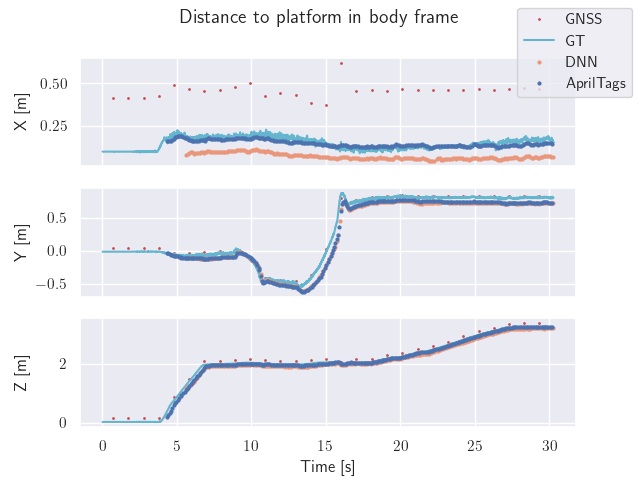

In [35]:
fig, axs = plt.subplots(3, 1)

axs[0].plot(gnss_data[:,0], gnss_data[:,1],'o', ms=1, c='r')
axs[0].plot(GT_data[:,0], GT_data[:,1], c='c')
axs[0].plot(dnn_data[:,0], dnn_data[:,1], 'o', ms=2, c='darksalmon')
axs[0].plot(apriltag_data[:,0], apriltag_data[:,1], 'o', ms=2, c='b')
# axs[0].plot(ekf_data[:,0], ekf_data[:,1], c='g')
# axs[0].fill_between(ekf_data[:,0], 
#                     y1=ekf_data[:,1] - np.sqrt(ekf_data[:,4]), 
#                     y2=ekf_data[:,1] + np.sqrt(ekf_data[:,4]), 
                    # alpha=.5, color='g')
axs[0].set_ylabel('X [m]')
axs[0].grid(True)
axs[0].set_xticklabels([])


axs[1].plot(gnss_data[:,0], gnss_data[:,2],'o', ms=1, c='r')
axs[1].plot(GT_data[:,0], GT_data[:,2], c='c')
axs[1].plot(dnn_data[:,0], dnn_data[:,2], 'o', ms=2, c='darksalmon')
axs[1].plot(apriltag_data[:,0], apriltag_data[:,2], 'o', ms=2, c='b')
# axs[1].plot(ekf_data[:,0], ekf_data[:,2], c='g')
# axs[1].fill_between(ekf_data[:,0], 
#                     y1=ekf_data[:,2] - np.sqrt(ekf_data[:,5]), 
#                     y2=ekf_data[:,2] + np.sqrt(ekf_data[:,5]), 
#                     alpha=.5, color='g')
axs[1].set_xticklabels([])
axs[1].set_ylabel('Y [m]')
axs[1].grid(True)
axs[1].set_xticklabels([])





axs[2].plot(gnss_data[:,0], gnss_data[:,3],'o', ms=1, c='r')
axs[2].plot(GT_data[:,0], GT_data[:,3], c='c')
axs[2].plot(dnn_data[:,0], dnn_data[:,3], 'o', ms=2, c='darksalmon')
axs[2].plot(apriltag_data[:,0], apriltag_data[:,3], 'o', ms=2, c='b')
# axs[2].plot(ekf_data[:,0], ekf_data[:,3], c='g')
# axs[2].fill_between(ekf_data[:,0], 
#                     y1=ekf_data[:,3] - np.sqrt(ekf_data[:,6]), 
#                     y2=ekf_data[:,3] + np.sqrt(ekf_data[:,6]), 
#                     alpha=.5, color='g')
axs[2].set_xlabel('Time [s]')
axs[2].set_ylabel('Z [m]')
axs[2].grid(True)

handles, labels = axs[2].get_legend_handles_labels()
labels = ["GNSS", "GT", "DNN", "AprilTags"]#, "EKF", r"$1\sigma$"]
fig.legend(labels, loc='upper right', ncol=1)
fig.suptitle('Distance to platform in body frame', fontsize=14)
fig.align_ylabels(axs)

plt.show()
# plt.savefig("figures_mission/all_measurements.svg")

# PRINT RMSE

In [19]:
def make_rmse_dataframe(df, column_names_to_keep):
  df_reduced = df[column_names_to_keep]

  RMSE_df = Mask_Or_Drop_Successive_Identical_Values(df_reduced, drop=True)

  return RMSE_df


RMSE_df = make_rmse_dataframe(df_merged_position, ["drone_to_platform_body_x", "drone_to_platform_body_y", "drone_to_platform_body_z", "ekf_x", "ekf_y", "ekf_z"])

RMSE_df["x_diff"] = RMSE_df["drone_to_platform_body_x"] - RMSE_df["ekf_x"]
RMSE_df['x_diff'] = RMSE_df['x_diff'].apply(lambda x: x**2)
print("RMSE X: ", np.sqrt((RMSE_df["x_diff"]).mean()))

RMSE_df["y_diff"] = RMSE_df["drone_to_platform_body_y"] - RMSE_df["ekf_y"]
RMSE_df['y_diff'] = RMSE_df['y_diff'].apply(lambda x: x**2)
print("RMSE Y: ", np.sqrt((RMSE_df["y_diff"]).mean()))

RMSE_df["z_diff"] = RMSE_df["drone_to_platform_body_z"] - RMSE_df["ekf_z"]
RMSE_df['z_diff'] = RMSE_df['z_diff'].apply(lambda x: x**2)
print("RMSE Z: ", np.sqrt((RMSE_df["z_diff"]).mean()))

NameError: name 'df_merged_position' is not defined

# WITHOUT GNSS 

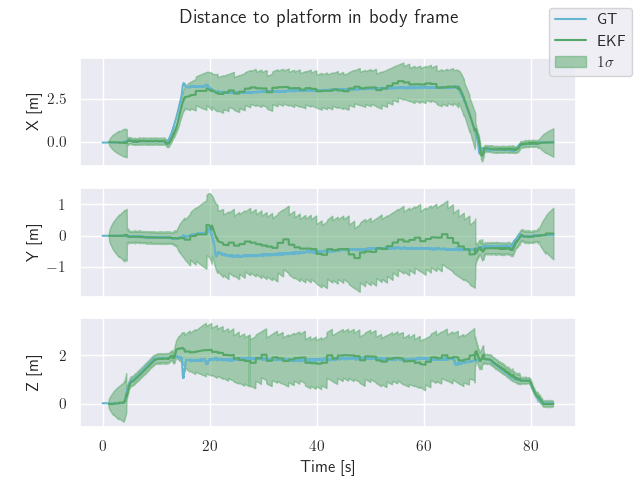

In [29]:
fig, axs = plt.subplots(3, 1)

axs[0].plot(GT_data[:,0], GT_data[:,1], c='c')
axs[0].plot(ekf_data[:,0], ekf_data[:,1], c='g')
axs[0].fill_between(ekf_data[:,0], 
                    y1=ekf_data[:,1] - np.sqrt(ekf_data[:,4]), 
                    y2=ekf_data[:,1] + np.sqrt(ekf_data[:,4]), 
                    alpha=.5, color='g')
axs[0].set_ylabel('X [m]')
axs[0].grid(True)
axs[0].set_xticklabels([])

axs[1].plot(GT_data[:,0], GT_data[:,2], c='c')
axs[1].plot(ekf_data[:,0], ekf_data[:,2], c='g')
axs[1].fill_between(ekf_data[:,0], 
                    y1=ekf_data[:,2] - np.sqrt(ekf_data[:,5]), 
                    y2=ekf_data[:,2] + np.sqrt(ekf_data[:,5]), 
                    alpha=.5, color='g')
axs[1].set_xticklabels([])
axs[1].set_ylabel('Y [m]')
axs[1].grid(True)
axs[1].set_xticklabels([])




axs[2].plot(GT_data[:,0], GT_data[:,3], c='c')
axs[2].plot(ekf_data[:,0], ekf_data[:,3], c='g')
axs[2].fill_between(ekf_data[:,0], 
                    y1=ekf_data[:,3] - np.sqrt(ekf_data[:,6]), 
                    y2=ekf_data[:,3] + np.sqrt(ekf_data[:,6]), 
                    alpha=.5, color='g')
axs[2].set_xlabel('Time [s]')
axs[2].set_ylabel('Z [m]')
axs[2].grid(True)

handles, labels = axs[2].get_legend_handles_labels()
labels = ["GT", "EKF", r"$1\sigma$"]
fig.legend(labels, loc='upper right', ncol=1)
fig.suptitle('Distance to platform in body frame', fontsize=14)
fig.align_ylabels(axs)

plt.show()

plt.savefig("figures_mission/all_measurements_only_ekf.svg")
